In [12]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\mechadmin\Documents\GitHub\pyiga\.venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


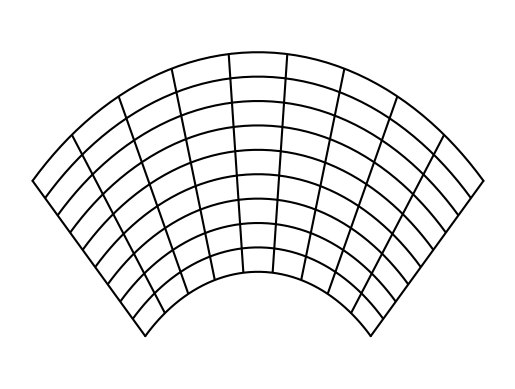

In [13]:
n = 2
f = geometry.circular_arc(pi/n)
g = geometry.line_segment([0.5,0.5], [1,1])
G = geometry.outer_product(f,g) # create pie slice
# vis.plot_geo(G)
G1 = G.rotate_2d(pi*0.25) # rotate pie slice to upright position
# vis.plot_geo(G1)
# print(pi/5)
G2 = G1.scale([0.726,1]) # stretch pie slice in x & y-dir
# G2 = G1.scale([pi/4,1]) # stretch pie slice in x & y-dir

# vis.plot_geo(G2)

geos = [
    G2,
    # G2.rotate_2d(pi*.4),
    # G2.rotate_2d(2*pi*.4),
    # G2.rotate_2d(3*pi*.4),
    # G2.rotate_2d(4*pi*.4),
]

for g in geos:
    vis.plot_geo(g)
    
axis('equal');
axis('off');

In [14]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.5, 1.0, 10),)

patches = [(kvs, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, automatch=True)

In [15]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g1 = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    (0, 'bottom', g1), 
    (0, 'top', g1),
    # (1, 'top', g1),
    # (2, 'left', g1), (2, 'bottom', g1),
    # (3, 'bottom', 0),
])

# assemble the linear system
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch
u_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u)
           for p in range(len(patches))]

In [ ]:
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();